# Computing the change per year for each pixel



In [1]:
#Allow for interactive figure display
%matplotlib notebook
#%matplotlib inline

In [89]:
#Import necessary modules
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy.ma as ma
from os.path import isfile, join

import xarray as xr
import glob

from pygeotools.lib import iolib, warplib, geolib, timelib, malib
# timelib does time series analysis

In [32]:
#Input DEM filenames

mypath = 'data'

filenames = os.listdir(mypath)

dem_fn_list = [join(mypath, f) for f in filenames if isfile(join(mypath, f))]
# sort them alphabetically
dem_fn_list = sorted(dem_fn_list)
#print(dem_fn_list)


In [87]:
ds_list = warplib.memwarp_multi_fn(dem_fn_list, extent='union', res='min', t_srs=dem_fn_list[-1])


Warping all inputs to the following:
Resolution: 32.0
Extent: [473230.772, 3085731.302, 497009.303, 3103537.631]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 29: data/20030507_0445_1010010001E01600_1010010001E01500-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
2 of 29: data/20121223_0456_1050410000E0AE00_1050410000E8C900-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
3 of 29: data/20121228_0506_102001001FB33300_102001002097D600-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
4 of 29: data/20130106_0456_102001001D141500_102001001DC53200-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
5 of 29: data/20131229_0456_10200100296A0900_10200100298D5F00-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
6 of 29: data/20140303_0447_1020010029AC1C00_102001002BD01800-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
7 of 29: data/20140307_0452_102001002C5CED00_102001002CCB4600-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
8 of 29: data/20140311_0458_102001002CDDFB

In [5]:
#Load datasets to NumPy masked arrays
dem_list = [iolib.ds_getma(i) for i in ds_list]

In [6]:
#Print some output info
print(dem_list[0].shape)
print(dem_list[0].dtype)

print(ds_list[0])

# It's masked to make sure that NA are viewed as NA in all different datasets, without deleting them

(556, 743)
float32
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f0cc854a810> >


## Time series of elevation change
We pick a pixel that has many DEM available and show the time series of the elevation change for only that pixel. 

In [39]:
# Picking a pixel of interest with a lot of DEM available

interest_idx = (184, 429)
#interest_idx = (184, 329)

times = []
for dem in dem_list:
    #print(summit_idx)
    #print('%0.1f m (%0.1f ft)' % (dem[summit_idx], (dem[summit_idx]*3.28084)))
    times.append(dem.data[interest_idx])
    
t_list = np.array([timelib.fn_getdatetime(fn) for fn in dem_fn_list])
# If we want to convert the time stamp to decimal years (not necessary)
#t_list = [timelib.dt2decyear(t) for t in t_list]

times=np.array(times)
#times = ma.masked_invalid(times)


<IPython.core.display.Javascript object>


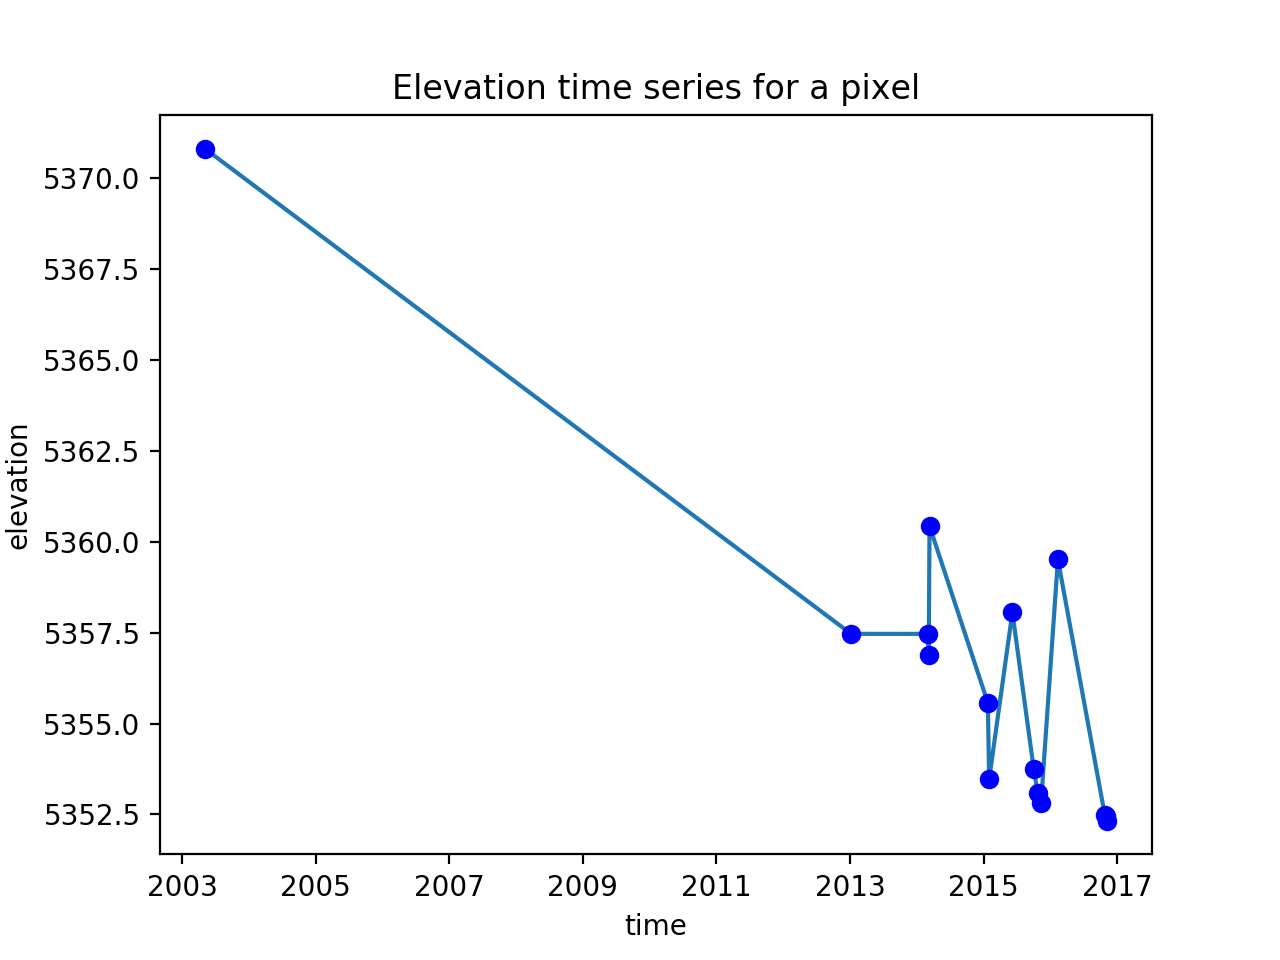

In [120]:
# Plotting the elevation change for that pixel

#fig = plt.Figure()
plt.figure(1)
plt.subplot(111)
#plt.plot(np.array(t_list), np.array(times))
#plt.plot(np.array(t_list)[~times.mask], times[~times.mask])
plt.plot(np.array(t_list)[times!=0], times[times!=0])
plt.plot(np.array(t_list)[times!=0], times[times!=0],'bo')
plt.xlabel('time')
plt.ylabel('elevation')
plt.title('Elevation time series for a pixel')
plt.savefig("elevation_per_pixel.png")
plt.show()

# Computing the time trend of elevation change per pixel
For the masked area

In [71]:
from sklearn import linear_model

change = np.zeros(dem_list[0].data.shape)

# figuring out the pixels indices that are on the glacier
glacier_area = np.ones(dem_list[0].data.shape)

khumbu_shape_filename = "khumbu_shape/khumbu_shape.shp"
khumbu_shp_mask = geolib.shp2array(khumbu_shape_filename, ds_list[0])
#plt.imshow(np.ma.array(change, mask=khumbu_shp_mask))
masked_glacier_area = np.ma.array(glacier_area, mask=khumbu_shp_mask)

masked_glacier_aoi = masked_glacier_area.nonzero()

# Getting the pixel coordinates
idx_vec = []
for i in range(0, len(masked_glacier_aoi[0])):
    idx_vec.append((masked_glacier_aoi[0][i],masked_glacier_aoi[1][i]))

print("number of pixels " + str(len(masked_glacier_aoi[0])))

#idx_vec = [(184, 429), (184, 329), (250, 429)]


# getting the vector of times
t_list = np.array([timelib.fn_getdatetime(fn) for fn in dem_fn_list])
# As fractions of year
t_list_num =np.array([timelib.dt2decyear(t) for t in t_list])[1:] # excludes 2003

# initializing the plot (but we now have too many observations)
#fig, ax = plt.subplots()

# computing the slope for every pixel in the idx_vec
for idx in idx_vec:
    #print(idx)
    elevation = []
    for dem in dem_list[1:]: # excludes 2003
        elevation.append(dem.data[idx])
        
    elevation=np.array(elevation)
    
    
    glacier_x = t_list_num[elevation!=0]
    glacier_y = elevation[elevation!=0]
    
    # If statement that constrains the selected pixels to data rich ones
    #if len(glacier_x)>4: # number of observations
    if glacier_x.max() - glacier_x.min() > 1: # time series spans more than x years
        #plt.plot(glacier_x, glacier_y)
    
        # Create linear regression object
        regr = linear_model.LinearRegression()

        # Train the model using the training sets
        regr.fit(glacier_x.reshape(-1, 1), glacier_y.reshape(-1, 1))

        # The coefficients
        #print('Coefficients: \n', regr.coef_[0])
        change[idx] = regr.coef_[0]

#plt.plot(glacier_x, glacier_y)
#plt.ylim((5000,7000))
#plt.xlabel('time')
#plt.ylabel('elevation')
#plt.title('Elevation per pixel')
#plt.savefig("elevation_per_pixel.png")
#plt.show()

Input shp srs: +proj=longlat +datum=WGS84 +no_defs 
Specified output srs: +proj=utm +zone=45 +datum=WGS84 +units=m +no_defs 
number of pixels 18649


<IPython.core.display.Javascript object>


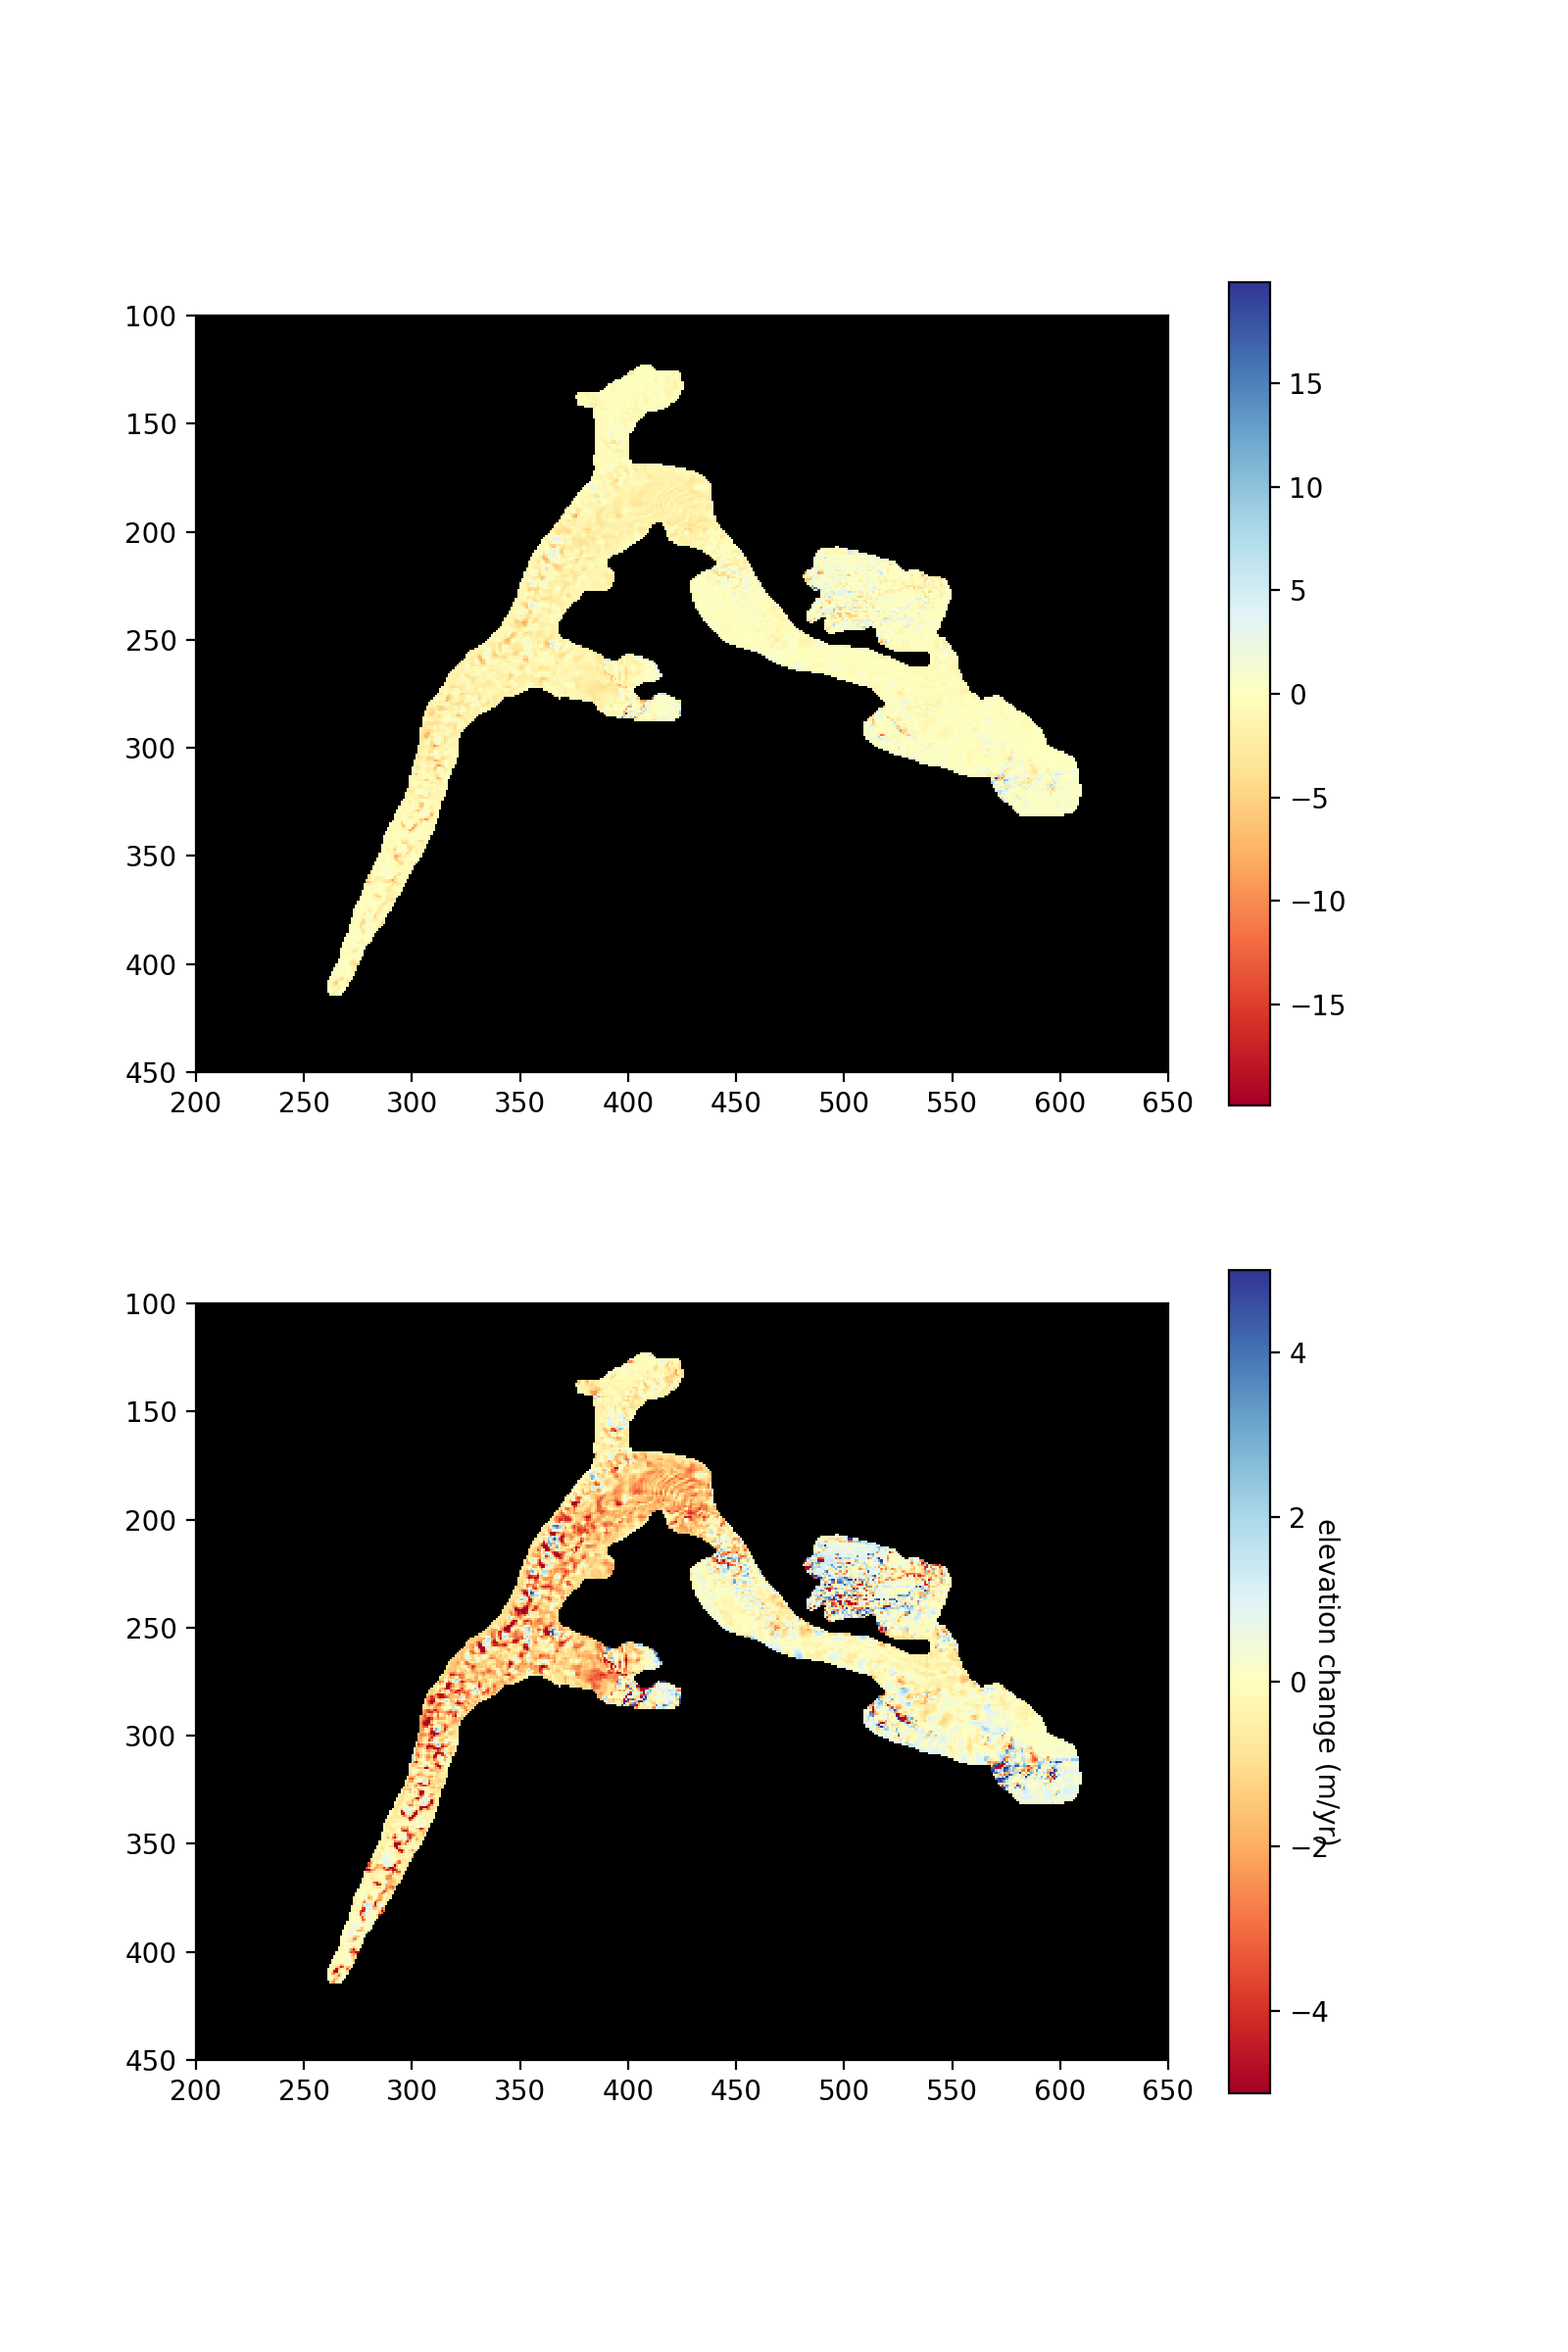

In [121]:
fig = plt.figure(figsize = (8,12))
plt.title('Elevation per pixel')
ax = plt.subplot(2, 1, 1)
plt.imshow(change, cmap='RdYlBu', vmin = -np.abs(change).max())
plt.colorbar()
cbar.set_label('elevation change (m/yr)', rotation=270)
change_zeros = change.copy()
change_zeros[change!=0] = np.nan
plt.imshow(change_zeros, cmap='binary', vmin = -np.abs(change).max())
plt.xlim((200, 650))
plt.ylim((450, 100))
ax = plt.subplot(2, 1, 2)
plt.imshow(change, cmap='RdYlBu', vmin=-5, vmax=5)
plt.xlim((200, 650))
plt.ylim((450, 100))
cbar = plt.colorbar()
cbar.set_label('elevation change (m/yr)', rotation=270)
plt.imshow(change_zeros, cmap='binary', vmin = -np.abs(change).max())
plt.savefig("elevation_change_map.png")

In [91]:

class RasterSource(object):
    FILE_ENDING = 'trans.tif'

    def __init__(self, folder):
        self._folder = folder

    def file_list(self):
        return glob.glob(
            os.path.join(self._folder, '') + '**/*' + self.FILE_ENDING,
            recursive=True
        )


files = RasterSource(
    'data/'
).file_list()

raster_list = warplib.memwarp_multi_fn(
    files, extent='union', res='min', t_srs=files[0]
)

band_data = [iolib.ds_getma(i).filled(np.NaN) for i in raster_list]

x, y = geolib.get_xy_grids(raster_list[0])
time_list = np.array([timelib.fn_getdatetime(fn) for fn in files])

x_band_data = xr.DataArray(
    np.stack(band_data),
    coords={
        'lat': y[::,0],
        'lon': x[0,::],
        'time': time_list
    },
    dims=('time', 'lat', 'lon'),
    name='elevation'
)





Warping all inputs to the following:
Resolution: 32.0
Extent: [473230.772, 3085731.302, 497009.303, 3103537.631]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 29: data/20151023_0456_1050010001C29900_1050010001C29B00-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
2 of 29: data/20140307_0452_102001002C5CED00_102001002CCB4600-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
3 of 29: data/20150527_0504_1030010043122E00_1030010040B19300-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
4 of 29: data/20150115_0456_1040010006A12900_104001000665F400-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
5 of 29: data/20121228_0506_102001001FB33300_102001002097D600-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
6 of 29: data/20141018_0511_1050410011888400_1050410011888300-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
7 of 29: data/20150204_0555_102001003A5B7900_1020010039598B00-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
8 of 29: data/20140303_0447_1020010029AC1C

In [94]:
x_band_data = x_band_data.sortby('time')
x_band_data['mean'] = x_band_data.mean(dim=('time'))
x_band_data['mean']

<xarray.DataArray 'mean' (lat: 556, lon: 743)>
array([[      nan, 5480.694 , 5480.282 , ...,       nan,       nan,       nan],
       [5477.599 , 5478.545 , 5480.491 , ..., 6489.004 , 6491.1694,       nan],
       [5477.92  , 5477.927 , 5479.456 , ..., 6492.239 , 6497.4795, 6518.652 ],
       ...,
       [4488.237 , 4495.649 , 4500.8267, ..., 6212.1196, 6243.125 ,       nan],
       [4481.77  , 4484.797 , 4474.422 , ..., 6206.4185, 6228.835 ,       nan],
       [      nan, 4475.828 , 4453.8516, ..., 6208.65  , 6228.285 ,       nan]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 3.104e+06 3.103e+06 3.103e+06 3.103e+06 3.103e+06 ...
  * lon      (lon) float64 4.732e+05 4.733e+05 4.733e+05 4.733e+05 4.734e+05 ...
    mean     (lat, lon) float32 nan 5480.694 5480.282 5491.1646 5500.694 nan ...

In [113]:
def plothist(ax, x, y, xlim, ylim, log=False):
    bins = (100, 100)
    #Generate and apply a common mask for the DEM and the elevation change arrays
    common_mask = ~(malib.common_mask([x,y]))
    x = x[common_mask]
    y = y[common_mask]
    H, xedges, yedges = np.histogram2d(x,y,range=[xlim,ylim],bins=bins)
    H = np.rot90(H)
    H = np.flipud(H)
    #Mask any bins with zero count
    Hmasked = np.ma.masked_where(H==0,H)
    H_clim = malib.calcperc(Hmasked, (5,95))
    if log:
        import matplotlib.colors as colors
        ax.pcolormesh(xedges,yedges,Hmasked,cmap='inferno',norm=colors.LogNorm(vmin=H_clim[0],vmax=H_clim[1]))
    else:
        ax.pcolormesh(xedges,yedges,Hmasked,cmap='inferno',vmin=H_clim[0],vmax=H_clim[1])
    #Plot a line for the max values in each elevation band
    Hmax_idx = np.ma.argmax(Hmasked, axis=0)
    ymax = (yedges[:-1]+np.diff(yedges))[Hmax_idx]
    #ax.plot(xedges[:-1]+np.diff(xedges), ymax, color='dodgerblue',lw=1.0)
    ax.axhline(0,lw=0.5,ls='-',c='limegreen')

<IPython.core.display.Javascript object>


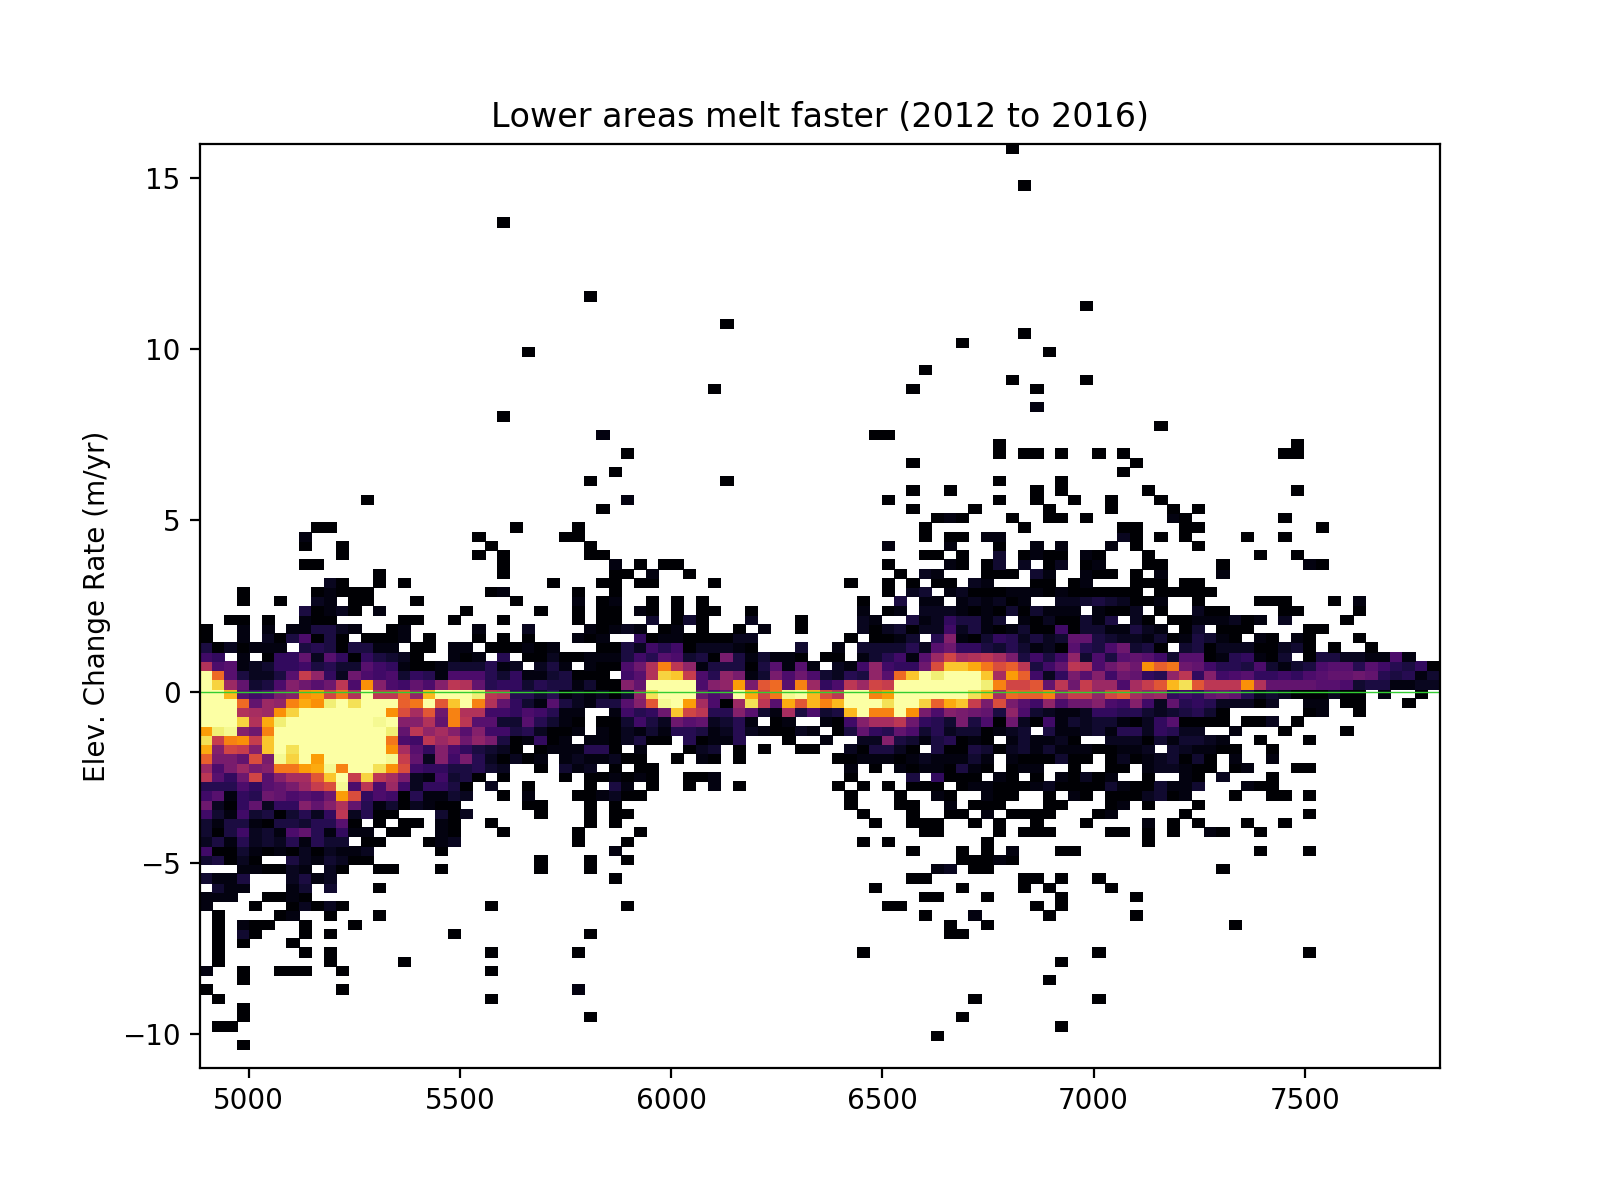

In [122]:
#print(x_band_data['mean'].values.flatten())
#print(change.flatten())

#plt.plot(np.array(x_band_data['mean'].values.flatten()), np.array(change.flatten()))
#plt.show()

#change_zeros = change.copy()
#change_zeros[change!=0] = np.nan

masked_mean=x_band_data['mean'].where(khumbu_shp_mask==False)

f, axa = plt.subplots(1, sharex=True, sharey=True, figsize=(8,6))
#dem_clim = (np.float32(x_band_data['mean'].min()), np.float32(x_band_data['mean'].max()))
dem_clim = (np.float32(masked_mean.min()), np.float32(masked_mean.max()))
#dem_clim = (1000,8400)
dhdt_clim = (-11, 16)

#plothist(axa, x_band_data['mean'].values, change, dem_clim, dhdt_clim)
plothist(axa, masked_mean.values, change, dem_clim, dhdt_clim)
axa.set_title('Lower areas melt faster (2012 to 2016)')
axa.set_ylabel('Elev. Change Rate (m/yr)')

#plothist(axa[1], dem_list[1], dhdt_list_shpclip[1], dem_clim, dhdt_clim)
#axa[1].set_title('2008 to 2015')
#axa[1].set_ylabel('Elev. Change Rate (m/yr)')
#axa[1].set_xlabel('Elevation (m WGS84)')
plt.show()
plt.savefig("change_by_elevation.png")

In [ ]:
#titles = ['05/2003', '12/2012', '03/2014', '02/2016']

#Find the 2nd and 98th percentile values to use for min/max limits of colorbar stretch
clim = malib.calcperc(dem_list[0], (2,98))
#plot3panel(dem_list, clim, titles, 'inferno', 'Elevation (m WGS84)')
plot3panel(dem_list, clim, "1234", 'inferno', 'Elevation (m WGS84)')